In [15]:
import pandas as pd
import numpy as np
import utils

# Data Preparation

In [16]:
datapath = './data/'
LAN_CSV_DCT, spc_csv = utils.read_csv(datapath)
LAN_NAME_ARR = np.array(spc_csv['LAN'])[:-2] # exclude MIN & MAX
LAN_NAME_LST = list(LAN_NAME_ARR)


Check all 210 files ...
Got 27 cfr files
['RTL8112' 'RTL8112L' 'RTL8131' '82567LF' 'RTL8103EL' 'AR8131L-AL1E'
 'WG82578DM' 'RTL8111E-VB' 'WG82567V' 'WG82583V' 'WG82579V' 'AR8151'
 'RTL8111E-VL' 'WG82579LM' 'RTL8111F-VB' 'AR8161-AL3A-R' 'AR8161-BL3A-R'
 'RTL8111DP-VC' 'WGI217V' 'RTL8111G-CG' 'RTL8111GR-CG' 'WGI217LM'
 'WGI218V' 'WGI211AT(A2)' 'WGI218LM' 'RTL8111EP-CG' 'RTL8111H-CG']


In [17]:
# NORMALIZE ALL VALUES

raw_spc = np.array(spc_csv.iloc[:,1:]) # exclude name
S_ALL = utils.create_S(raw_spc)
s_scaler, S_ALL_NORM = utils.scale(S_ALL)
print ("S_ALL_NORM.shape: {0}".format(S_ALL_NORM.shape))

ftr_dct = utils.show_spc(S_ALL, LAN_NAME_ARR, printout = True)

S_ALL_NORM.shape: (29, 13)
|             |Tmst |Year |Mont |New  |IC2L |Nm2G |Nm2L |AD2G |AD2L |Gd2G |Gd2L |PwPn |ESD  |
|LAN          |a_Ts |b_Yr |c_Mt |d_N  |e_IL |f_NG |g_NL |h_AG |i_AL |j_GG |k_GL |l_Pn |m_ED |
|-            |-    |-    |-    |-    |-    |-    |-    |-    |-    |-    |-    |-    |-    |
|RTL8112      | 1230739200.00| 2009.00| 1.00| 0.00| 1.00| 4.00| 1.00| 6.00| 1.00| 15.00| 6.00| 6.00| 8.00|
|RTL8112L     | 1235836800.00| 2009.00| 3.00| 0.00| 1.00| 4.00| 1.00| 6.00| 1.00| 15.00| 6.00| 6.00| 8.00|
|RTL8131      | 1235836800.00| 2009.00| 3.00| 0.00| 1.00| 4.00| 1.00| 6.00| 1.00| 15.00| 6.00| 6.00| 8.00|
|82567LF      | 1246377600.00| 2009.00| 7.00| 0.00| 1.00| 4.00| 1.00| 6.00| 1.00| 15.00| 6.00| 6.00| 8.00|
|RTL8103EL    | 1249056000.00| 2009.00| 8.00| 0.00| 1.00| 4.00| 1.00| 6.00| 1.00| 15.00| 6.00| 6.00| 8.00|
|AR8131L-AL1E | 1254326400.00| 2009.00| 10.00| 0.00| 1.00| 4.00| 1.00| 6.00| 1.00| 15.00| 6.00| 5.00| 8.00|
|WG82578DM    | 1262275200.00| 2010.00| 1.00| 0.

In [18]:
import _Library._Utils_FileHandler as fh
import _Library._Init_Head
# %run ./_Library/_Init_Head

In [19]:
import sys
import math
import h5py
import scipy
from scipy import ndimage
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.python.framework import ops


import keras
from keras import backend as K
from keras.models import load_model, Model, Sequential
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, GRU,\
                         Multiply, Flatten, Embedding, SimpleRNN, RepeatVector, Dense,\
                         Activation, Lambda, Reshape, Dropout
from keras import callbacks as Kcallback
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Activation
from keras import __version__ as keras__version__

def swish(x):
    return x * K.sigmoid(x)

def binary(x):
    return keras.backend.switch(x < 0, x*0, x/x)

def bround(x):
    return keras.backend.switch(x < 0, x*0, keras.backend.round(x))

K.linear = 'linear'


# Prepare (X, Y), Setup Feature Space, Para., and Load Model

In [20]:
LN5_SET = ['RTL8111E-VL', 'RTL8111F-VB', 'RTL8111G-CG', 'RTL8111GR-CG', 'RTL8111H-CG']
L10_SET = ['RTL8111E-VL', 'RTL8111F-VB', 'RTL8111G-CG', 'RTL8111GR-CG', 'RTL8111H-CG',
           'AR8131L-AL1E', 'WG82579V', 'AR8161-AL3A-R', 'WGI217V', 'WGI218V']
LN8_SET = ['RTL8111E-VL', 'RTL8111F-VB', 'RTL8111G-CG', 'RTL8111GR-CG', 'RTL8111H-CG',
           'AR8131L-AL1E', 'WG82579V', 'WGI218V']


LTB_SET = ['RTL8112L', 'AR8131L-AL1E', 'RTL8111E-VB', 'RTL8111E-VL', 'RTL8111F-VB',
           'AR8161-BL3A-R', 'RTL8111G-CG', 'RTL8111GR-CG', 'WGI218V', 'RTL8111H-CG']

L27_SET = ['RTL8112', 'RTL8112L', 'RTL8131', '82567LF', 'RTL8103EL', 'AR8131L-AL1E',
           'WG82578DM', 'RTL8111E-VB', 'WG82567V', 'WG82583V', 'WG82579V', 'AR8151',
           'RTL8111E-VL', 'WG82579LM', 'RTL8111F-VB', 'AR8161-AL3A-R', 'AR8161-BL3A-R',
           'RTL8111DP-VC', 'WGI217V', 'RTL8111G-CG', 'RTL8111GR-CG', 'WGI217LM',
           'WGI218V', 'WGI211AT(A2)', 'WGI218LM', 'RTL8111EP-CG', 'RTL8111H-CG']

L18_SET = ['RTL8112L', 'AR8131L-AL1E', 'RTL8111E-VB', 'WG82567V', 'WG82583V',
           'WG82579V', 'RTL8111E-VL', 'WG82579LM', 'RTL8111F-VB', 'AR8161-AL3A-R',
           'AR8161-BL3A-R', 'WGI217V', 'RTL8111G-CG', 'RTL8111GR-CG', 'WGI217LM',
           'WGI218V', 'WGI211AT(A2)', 'RTL8111H-CG']
L13_SET = ['RTL8112L', 'AR8131L-AL1E', 'RTL8111E-VB', 'WG82579V', 'RTL8111E-VL',
           'RTL8111F-VB', 'AR8161-AL3A-R', 'AR8161-BL3A-R', 'WGI217V', 'RTL8111G-CG',
           'RTL8111GR-CG', 'WGI218V', 'RTL8111H-CG']
L12_SET = ['RTL8112L', 'AR8131L-AL1E', 'RTL8111E-VB', 'WG82579V', 'RTL8111E-VL',
           'RTL8111F-VB', 'AR8161-AL3A-R', 'AR8161-BL3A-R', 'WGI217V', 'RTL8111G-CG',
           'RTL8111GR-CG', 'WGI218V']
L25_SET = ['RTL8112', 'RTL8112L', 'RTL8131', 'RTL8103EL', 'AR8131L-AL1E',
           'WG82578DM', 'RTL8111E-VB', 'WG82567V', 'WG82583V', 'WG82579V',
           'RTL8111E-VL', 'WG82579LM', 'RTL8111F-VB', 'AR8161-AL3A-R', 'AR8161-BL3A-R',
           'RTL8111DP-VC', 'WGI217V', 'RTL8111G-CG', 'RTL8111GR-CG', 'WGI217LM',
           'WGI218V', 'WGI211AT(A2)', 'WGI218LM', 'RTL8111EP-CG', 'RTL8111H-CG']

In [21]:
import os
import re

track_num = '20181001000'
MODEL_PATH = None
for dirname, dirnames, filenames in os.walk('./ongo/' + track_num + "/"):
    # go through all entries
    for filename in filenames:
        if filename.endswith('.h5'):
            filepath = os.path.join(dirname, filename)    
            MODEL_PATH = filepath
        
print(MODEL_PATH)

ftr_set = [0] + list(range(4, S_ALL_NORM.shape[1])); VERSION = 2; TAR_NAMES = LTB_SET;

TARGET = sorted(set(spc_csv.loc[spc_csv['LAN'].isin(TAR_NAMES)].index.tolist()))

ffx = ""
for v in ftr_set:
    ffx += chr(v+97)
print("ffx: %s" % ffx)

./ongo/20181001000/CFR_MODEL_LSTM[LrDsDsDsDsDr_f11hn512bs3dp0.001]_ModelInf_R0_aefghijklm_v2_LTB_spc1.h5
ffx: aefghijklm


In [22]:

c_dft_norm, _, C_SCALER = utils.create_C(LAN_CSV_DCT, LAN_NAME_ARR, TARGET)
s_all_norm = S_ALL_NORM[:, ftr_set]
print("s_all_norm: {0}".format(s_all_norm.shape))
s_all_norm_f = S_ALL_NORM[TARGET][:, ftr_set]
print("s_all_norm_f: {0}".format(s_all_norm_f.shape))



Target ids: [1, 5, 7, 12, 14, 16, 19, 20, 22, 26]
c_norm.shape: (10, 36, 1)
s_all_norm: (29, 10)
s_all_norm_f: (10, 10)


In [23]:
pred_timesteps = 36

_, _, F, Y = utils.get_xy_from_sAc(s_all_norm_f, c_dft_norm, pred_timesteps, list(range(c_dft_norm.shape[0])))
X = F[:,:,(3-VERSION):]
input_features = X.shape[2]
output_features = Y.shape[2]
hidden_neurons = 512

print("Load from {0} ...".format(MODEL_PATH))
model_inf = load_model(MODEL_PATH, custom_objects={'swish': swish, 'binary': binary, 'bround': bround})
print("Done")

Load from ./ongo/20181001000/CFR_MODEL_LSTM[LrDsDsDsDsDr_f11hn512bs3dp0.001]_ModelInf_R0_aefghijklm_v2_LTB_spc1.h5 ...
Done


/home/jerry3chang/Workspace/tensorflow_py3/lib/python3.5/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [24]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(inference_model, show_shapes=True).create(prog='dot', format='svg'))

from IPython.display import Image
# Image(model_to_dot(model_inf, show_shapes=True).create(prog='dot', format='png'))

# KNN Search Implementation

[148  96 110 173   5 178  20  13  42  56]


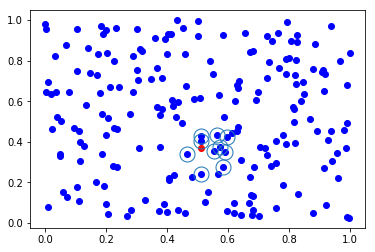

In [25]:
from numpy import random,argsort,sqrt
from pylab import plot,show

def knn_search(x, D, K):

    """ find K nearest neighbours of data among D """
    ndata = D.shape[1]
    K = K if K < ndata else ndata
    # euclidean distances from the other points
    sqd = sqrt(((D - x[:,:ndata])**2).sum(axis=0))
    
    #print("len(sqd): {0}".format(len(sqd)))
    #print("sqd.shape: {0}".format(sqd.shape))

    idx = argsort(sqd) # sorting
    # return the indexes of K nearest neighbours
    return idx[:K]


# knn_search test
data = random.rand(2,200) # random dataset
x = random.rand(2,1) # query point

A = data - x[:,:data.shape[1]]
B = (data - x[:,:data.shape[1]])**2
C = B.sum(axis=0)
# performing the search
neig_idx = knn_search(x,data,10)

print(neig_idx)


# plotting the data and the input point
plot(data[0,:],data[1,:],'ob' ,x[0,0],x[1,0],'or')
# highlighting the neighbours
plot(data[0,neig_idx],data[1,neig_idx],'o',
  markerfacecolor='None',markersize=15,markeredgewidth=1)
show()

In [26]:
A = None
A = [1]
if A:
    print("Got A!")
else:
    print("Noneeeee!")

Got A!


In [55]:
def gen_data(dim, ndata, distance, seed, debug = False):

    data = seed
    
    print("Generating for [dim: {0}, ndata: {1}, dist: {2}] ...".format(dim, ndata, distance))
    
    att = 0; total_att = 0; max_att = ndata * dim;
    print("base: {0}\n".format(["{:0.3f}".format(e) for e in data.reshape(-1)])) if debug else False

    batch_size = ndata / 4    
    
    flag = False

    while data.shape[1] < ndata and att < max_att:

        att += 1; total_att += 1;
        x = random.rand(dim,1)
        print("x: {0}".format(["{:0.3f}".format(e) for e in x.reshape(-1)])) if debug else False
        
        D = sqrt(((data - x[:,:data.shape[1]])**2).sum(axis=0))
        print(["{:0.3f}".format(e) for e in D]) if debug else False
        if min(D) > distance:
            data = np.concatenate((data, x), axis = 1)
            flag = True

        if flag:
            print("data.shape: {0} (# of attempts = {1})\n".format(data.shape, att)) if debug else False
            
            if data.shape[1] >= ndata:
                print("{0} points (loops: {1}) Done!".format(data.shape[1], total_att)) if debug else False
            elif data.shape[1] % batch_size == 0:
                print("{0} points (loops: {1}) ...".format(data.shape[1], total_att)) if debug else False
            
            att = 0
            flag = False

        if att >= max_att:
            print("Stop since almost impossible!")
    
    print("Done")
    
    filename = "data_dim" + str(dim) + "n" + str(data.shape[1]) + "dist" + str(distance) + ".csv"
    
    np.savetxt(filename, data, delimiter=",", fmt='%s')
    return data
    


In [28]:
import pylab

DIM = 9; NDATA = 1000; DIST = 0.5;
data_d9n1000d5 = gen_data(dim=DIM, ndata=NDATA, distance=DIST, seed = random.rand(DIM,1), debug=False)
# filename = "data_dim" + str(DIM) + "n" + str(NDATA) + "dist" + str(DIST) + ".csv"
# data_d9n1000d5 = np.genfromtxt("./ongo/" + filename, delimiter=',')


Generating for [dim: 9, ndata: 1000, dist: 0.5] ...
250 points (loops: 307) ...
500 points (loops: 765) ...
750 points (loops: 1538) ...
1000 points (loops: 2583) Done!


In [29]:

data = data_d9n1000d5

def quick_shot(data):
    print("Quick shot ...")
    if data.shape[0] <= 2:
        print("Short of dim!")
        return
    pylab.xlim(0,1)
    pylab.ylim(0,1)
    pylab.plot(data[0,:],data[1,:],'ob', markersize=3)
    show()
    pylab.plot(data[3,:],data[1,:],'or', markersize=3)
    show()
    if data.shape[0] > 5:
        pylab.plot(data[0,:],data[5,:],'og', markersize=3)
        show()
    if data.shape[0] > 7:
        pylab.plot(data[0,:],data[7,:],'oy', markersize=3)
        show()
    if data.shape[0] > 8:
        pylab.plot(data[8,:],data[4,:],'ok', markersize=3)
        show()
    return

# quick_shot(data)

# Predict for each sample

In [30]:
print (LAN_NAME_ARR)

['RTL8112' 'RTL8112L' 'RTL8131' '82567LF' 'RTL8103EL' 'AR8131L-AL1E'
 'WG82578DM' 'RTL8111E-VB' 'WG82567V' 'WG82583V' 'WG82579V' 'AR8151'
 'RTL8111E-VL' 'WG82579LM' 'RTL8111F-VB' 'AR8161-AL3A-R' 'AR8161-BL3A-R'
 'RTL8111DP-VC' 'WGI217V' 'RTL8111G-CG' 'RTL8111GR-CG' 'WGI217LM'
 'WGI218V' 'WGI211AT(A2)' 'WGI218LM' 'RTL8111EP-CG' 'RTL8111H-CG']


In [31]:
data_trans = data.T

In [32]:
import time as time_mod
import datetime as dt_mod

evl = [2011., 1., 1., 4., 1., 6., 1., 15., 6, 7.5, 8.]

dt = dt_mod.datetime(year=int(evl[0]), month=int(evl[1]), day=1)
ftr_a = time_mod.mktime(dt.timetuple())
evl_fix = [ftr_a] + evl[:2] + [-1.] + evl[2:]
print(evl_fix)


evl_fix_bo = np.array(evl_fix + evl_fix).reshape(2, 13)


ftr_data_norm = s_scaler.transform(np.array(evl_fix).reshape(1,13))
print(ftr_data_norm)
ftr_data_orig = s_scaler.inverse_transform(ftr_data_norm)
print(ftr_data_orig)

# ftr_data_norm = s_scaler.transform(evl_fix_bo)
# print(ftr_data_norm)
# ftr_data_orig = s_scaler.inverse_transform(ftr_data_norm)
# print(ftr_data_orig)


[1293811200.0, 2011.0, 1.0, -1.0, 1.0, 4.0, 1.0, 6.0, 1.0, 15.0, 6, 7.5, 8.0]
[[ 0.37691381  0.4         0.         -0.2         0.05        0.2
   0.05        0.3         0.05        0.75        0.3         0.375
   0.4       ]]
[[ 1.2938112e+09  2.0110000e+03  1.0000000e+00 -1.0000000e+00
   1.0000000e+00  4.0000000e+00  1.0000000e+00  6.0000000e+00
   1.0000000e+00  1.5000000e+01  6.0000000e+00  7.5000000e+00
   8.0000000e+00]]


In [33]:
import release.model.predict_models as predict_models

In model
/home/jerry3chang/Workspace/AMACS/CFR-Model/LAN-Model/release/model/
aefghijklm


/home/jerry3chang/Workspace/tensorflow_py3/lib/python3.5/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [34]:

NA = np.array([-1.] * 1000).reshape(1000, 1)
random_arr = np.concatenate((NA, NA, NA, NA, data.T), axis = -1)
res = s_scaler.inverse_transform(random_arr)[:,4:]

Y = 2016.
M = 5.
dt = dt_mod.datetime(year=int(Y), month=int(M), day=1)
TP = time_mod.mktime(dt.timetuple())
TA = np.array([TP] * 1000).reshape(1000, 1)
YA = np.array([Y] * 1000).reshape(1000, 1)
MA = np.array([M] * 1000).reshape(1000, 1)

sample_array = np.concatenate((TA, YA, MA, NA, res), axis = -1)



In [65]:
"""
sample_array of shape <# of samples, # of dim.>
"""
def predict_sample(predict_models, sample_array, debug=True):

    tb = dt_mod.datetime.now()

    CFO = [] # store orginal scale
    CFN = [] # store scaled cfr
    
    batch_size = int(sample_array.shape[0] / 4)
    
    cnt = 0
    
    for single_sample in sample_array:
        
        #sl = [1, 2] + list(range(4,13))
        
        single_input = list(single_sample) #list(single_sample[sl])
        cfn_str = predict_models.run('LAN', single_input, 36)['cfr_norm']
        cfo_str = predict_models.run('LAN', single_input, 36)['cfr']
        cfn_lst = cfn_str.split(',')
        cfo_lst = cfo_str.split(',')
        last_cfn = float(cfn_lst[-1])
        last_cfo = float(cfo_lst[-1])
        if cnt % batch_size == 0:
            print("last_cfr of sample {0}: {1:0.5f} ({2:0.5f})".format(cnt, last_cfn, last_cfo))\
            if debug else False
        CFO.append(last_cfo)
        CFN.append(last_cfn)
        cnt += 1

    tf = dt_mod.datetime.now()
    te = tf - tb

    print("Time elapsed: {0}".format(te))
    return CFO, CFN

In [36]:
print(sample_array.shape)

(1000, 13)


In [38]:
def quick_result(sample_array, ids, CFO, printout = True):

    S = " "
    for i in range(91):
        S += "_"
    print(S) if printout else False

    S = ""
    N = ['a_Ts','b_Yr','c_Mt','d_N','e_IL','f_NG','g_NL','h_AG','i_AL','j_GG','k_GL','l_Pn','m_ED']
    for v in N:
        S += "{:5s}|".format(v)
    print("|{0:13s}|{1}".format("LAN", S)) if printout else False
    S = "";
    for v in ["-"]*13:
        S += "{:5s}|".format(v)
    print("|{0:13s}|{1}".format("-", S)) if printout else False

    for idx in ids:
        row = sample_array[idx]
        S = "     |"
        for j in range(len(row)):
            if j < 2:
                S += " {0:s}|".format(str(row[j])[:4])
            elif j == 2:
                S += "     |"
                S += " {0:4s}|".format(str(int(row[j])))
            else:
                S += " {0:4s}|".format(str(int(row[j])))

        print("|{0:13s}|{1} {2:0.5f}".format("idx "+str(idx), S, CFO[idx])) if printout else False
    S = " "
    for i in range(91):
        S += "-"
    print(S) if printout else False


def sort_and_show(CFO, sample_array, printout = True):

    idxcnt = list(range(0,len(CFO),int(len(CFO)/3)))
    # print("idxcnt: {0}".format(idxcnt))

    last_cfr_arr = np.array(CFO)

    idx = argsort(last_cfr_arr) # sorting

    idx_select = idx[0:len(CFO):int(len(CFO)/3)]

    res = sample_array[idx_select]
    
    quick_result(sample_array, idx_select, CFO, printout=printout)

    return idx


In [43]:
DIM = 11; NDATA = 100; DIST = 0.9;
data_d11n100d5 = gen_data(dim=DIM, ndata=NDATA, distance=DIST, seed = random.rand(DIM,1), debug=False)


Generating for [dim: 11, ndata: 100, dist: 0.9] ...
25 points (loops: 35) ...
50 points (loops: 139) ...
75 points (loops: 293) ...
100 points (loops: 525) Done!


In [44]:
# quick_shot(data_d11n100d5)

In [45]:
print(data_d11n100d5.T[:3])

[[0.8000877  0.34465977 0.40777027 0.06539139 0.30342218 0.88705792
  0.27831653 0.38440438 0.91121919 0.27235941 0.33769079]
 [0.86953417 0.8245915  0.41770084 0.55526718 0.5845761  0.06113736
  0.42414362 0.22397526 0.53291774 0.97435421 0.33559365]
 [0.24939751 0.57075093 0.83848164 0.44045048 0.43525636 0.93660244
  0.48976895 0.82532438 0.44057398 0.41666805 0.86734727]]


In [46]:

# note data shape <# of samples, # of dim.>
def gen_sample_arr(data, s_scaler, inv = True):
    n = data.shape[0]
    NA = np.array([-1.] * n).reshape(n, 1)
    YA = data[:,0].reshape(n, 1)
    MA = data[:,1].reshape(n, 1)
    SA = data[:,2:]
    random_arr = np.concatenate((NA, YA, MA, NA, SA), axis = -1)
    sel = [1, 2] + list(range(4, random_arr.shape[1]))
    if inv:
        res = s_scaler.inverse_transform(random_arr)[:,sel]
    else:
        res = s_scaler.transform(random_arr)[:,sel]
    return res

In [47]:
sample_array = gen_sample_arr(data_d11n100d5.T, s_scaler)
print("sample_array.shape: {0}".format(sample_array.shape))

sample_array.shape: (100, 11)


In [48]:
CFO, CFN = predict_sample(predict_models, sample_array)

last_cfr of sample 0: 0.34984 (0.09166)
last_cfr of sample 25: 1.05559 (0.27657)
last_cfr of sample 50: 0.09082 (0.02380)
last_cfr of sample 75: 0.14709 (0.03854)
Time elapsed: 0:00:20.260035


In [49]:
idx = sort_and_show(CFO, sample_array)

 ___________________________________________________________________________________________
|LAN          |a_Ts |b_Yr |c_Mt |d_N  |e_IL |f_NG |g_NL |h_AG |i_AL |j_GG |k_GL |l_Pn |m_ED |
|-            |-    |-    |-    |-    |-    |-    |-    |-    |-    |-    |-    |-    |-    |
|idx 69       |     | 2019| 8.88|     | 6   | 3   | 18  | 3   | 14  | 18  | 12  | 0   | 1   | 0.00551
|idx 64       |     | 2018| 4.41|     | 7   | 18  | 16  | 16  | 13  | 14  | 0   | 18  | 19  | 0.05948
|idx 6        |     | 2016| 11.7|     | 7   | 9   | 1   | 10  | 17  | 15  | 4   | 19  | 9   | 0.23392
|idx 28       |     | 2011| 8.07|     | 11  | 19  | 1   | 3   | 0   | 3   | 8   | 9   | 4   | 0.33250
 -------------------------------------------------------------------------------------------


In [68]:
d_lst = [0.9, 0.5, 0.1]

def NNS(predict_models, s_scaler, d_lst):

    NDATA = 100; DIM = 11;
    
    def seedNNS(predict_models, s_scaler, d_lst, level, seed_lst):
        
        for seed in seed_lst:
            
            print("LEVEL {0}, seed: {1}".format(level, seed.T))

            data = gen_data(dim=DIM, ndata=NDATA, distance=d_lst[level], seed = seed)

            sample_array = gen_sample_arr(data.T, s_scaler)

            #print("Got inversed array of shape {0}".format(sample_array.shape))
            #print("Predict ...")

            CFO, CFN = predict_sample(predict_models, sample_array, debug=False)
            #print("Quick result ...")

            idx = sort_and_show(CFO, sample_array, printout=False)
            best = idx[:3]

            print("Best: {0}".format(best))

            #quick_result(sample_array, best, CFO)

            if level == 2:
                return
            else:
                new_array = gen_sample_arr(sample_array[best], s_scaler, inv=False)
                L = [e.reshape(DIM,1) for e in new_array]
                seedNNS(predict_models, s_scaler, d_lst, level+1, L)

    seedNNS(predict_models, s_scaler, d_lst, 0, [random.rand(DIM,1)])
    return

In [69]:
NNS(predict_models, s_scaler, d_lst)

LEVEL 0, seed: [[0.35793018 0.41737862 0.13095666 0.831898   0.32199817 0.50955362
  0.50838983 0.86253705 0.33727262 0.95402129 0.821416  ]]
Generating for [dim: 11, ndata: 10, dist: 0.9] ...
Done
Time elapsed: 0:00:01.965484
Best: [2 1 5]
LEVEL 1, seed: [[0.87345504 0.05956677 0.17910871 0.40758265 0.9879144  0.57284889
  0.85675627 0.22681432 0.52782698 0.26699488 0.04481182]]
Generating for [dim: 11, ndata: 10, dist: 0.5] ...
Done
Time elapsed: 0:00:02.203388
Best: [0 9 5]
LEVEL 2, seed: [[0.87345504 0.05956677 0.17910871 0.40758265 0.9879144  0.57284889
  0.85675627 0.22681432 0.52782698 0.26699488 0.04481182]]
Generating for [dim: 11, ndata: 10, dist: 0.1] ...
Done
Time elapsed: 0:00:02.135348
Best: [0 7 9]
LEVEL 1, seed: [[0.6086168  0.6016026  0.6888047  0.6174213  0.7824202  0.61992081
  0.56589101 0.49152085 0.038153   0.21348903 0.25735466]]
Generating for [dim: 11, ndata: 10, dist: 0.5] ...
Done
Time elapsed: 0:00:02.102463
Best: [0 7 6]
LEVEL 2, seed: [[0.6086168  0.601602